In [1]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import geometry
import itertools
from collections import defaultdict
import collections
import target
import controler
import utils
from functools import reduce
import linear_regression
from multiprocessing import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import feedexp3
import geometry_v2
import cpb
import feedexp3_v2
import bpm
import random_algo
import feedexp3_v3
import plotly.graph_objects as go
import TSPM
import eTSPM
import ucbtspm

def evaluate_parallel(nbCores, n_folds, horizon, alg, game):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon)
    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), range(n_folds) ) ) 


def get_easy(c = 2):

    res = False
    while res == False:
        pbt = np.random.uniform(0,1,5)
        pbt = pbt / pbt.sum()
        test = np.array([ pbt[i]>=c/(c+1) * pbt[i-1] for i in range(1, 5)])
        res = test.all()
    return pbt

def get_harsch(c = 2):

    res = True
    while res:
        pbt = np.random.uniform(0,1,5)
        pbt = pbt / pbt.sum()
        test = np.array([ pbt[i]>=c/(c+1) * pbt[i-1] for i in range(1, 5)])
        if (test == False).any():
            res = False
    return pbt

class Evaluation:

    def __init__(self, horizon ):
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, jobid):

        np.random.seed(jobid)

        p = get_easy() if game.mode == 'easy' else get_harsch() 
        outcome_distribution =  {'a':p[0],'b':p[1],'c':p[2],'d':p[3],'e':p[4]}

        game.set_outcome_distribution( outcome_distribution )
        # print('optimal action', game.i_star)

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]

            # print('t', t, 'action', action, 'outcome', outcome, )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome)
            
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return regret


n-actions 5 n-outcomes 5 alphabet 2
limit trial exceeded
limit trial exceeded
limit trial exceeded
limit trial exceeded
limit trial exceeded
limit trial exceeded


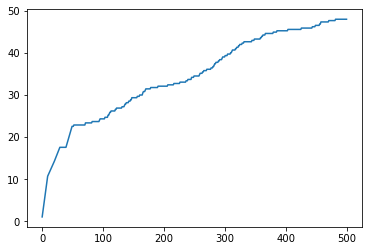

In [2]:

n_cores = 1
n_folds = 1
horizon = 500

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

game =  games.dynamic_pricing( 'hard' ) 

# print('optimal action', game.i_star)
alg = TSPM.TSPM_alg(  game, horizon,)
task = Evaluation(horizon)

result = task.eval_policy_once(alg,game, 5)
plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


In [2]:
n_cores = 16
n_folds = 15
horizon = 2000
# outcome_distribution =  {'spam':0.05,'ham':0.95}
import ucbTSPM_v2

game = games.dynamic_pricing( 'harsch' )

algos = [ random_algo.Random(  game, horizon, ), 
           feedexp3.FeedExp3(  game, horizon, ),
           feedexp3_v3.FeedExp3(  game, horizon, ), 
        #   cpb.CPB(  game, horizon,),  ]
           TSPM.TSPM_alg(  game, horizon,), 
        #    eTSPM.eTSPM_alg(  game, horizon, 1),
           ucbTSPM_v2.TSPM_alg(game, horizon)    ] #TSPM.TSPM_alg(  game, horizon,), bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) ) ,

colors = [ [0,0,0], [29,176,0], [155,155,0], [255,0,0], [0,0,255] ] # [255,0,0], [0,0,255] , [255,51,255], [255,20,200]  ] #
labels = ['random', 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'TSPM' ,  'ucbTSPM (Auer)' ]#  'CPB', 'TSPM' , 'eTSPM (Auer)', 'ucbTSPM (Auer)'  ]  # 

fig = go.Figure( )

fig = go.Figure( )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=True )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 100] )
fig.show()

n-actions 5 n-outcomes 5 alphabet 2
n-actions 5 n-outcomes 5 alphabet 2
nbCores: 16 nbFolds: 15 Horizon: 2000
nbCores: 16 nbFolds: 15 Horizon: 2000
nbCores: 16 nbFolds: 15 Horizon: 2000
nbCores: 16 nbFolds: 15 Horizon: 2000
nbCores: 16 nbFolds: 15 Horizon: 2000


In [3]:
n_cores = 16
n_folds = 25
horizon = 500
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.dynamic_pricing( 'easy' )


algos = [ random_algo.Random(  game, horizon, ), 
           feedexp3.FeedExp3(  game, horizon, ),
           feedexp3_v3.FeedExp3(  game, horizon, ), 
        #   cpb.CPB(  game, horizon,),  ]
           TSPM.TSPM_alg(  game, horizon,), 
        #    eTSPM.eTSPM_alg(  game, horizon, 1),
           ucbTSPM_v2.TSPM_alg(game, horizon)    ] #TSPM.TSPM_alg(  game, horizon,), bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) ) ,

colors = [ [0,0,0], [29,176,0], [155,155,0], [255,0,0], [0,0,255] ] # [255,0,0], [0,0,255] , [255,51,255], [255,20,200]  ] #
labels = ['random', 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'TSPM' ,  'ucbTSPM (Auer)' ]#  'CPB', 'TSPM' , 'eTSPM (Auer)', 'ucbTSPM (Auer)'  ]  # 


fig = go.Figure( )

fig = go.Figure( )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=True )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 60] )
fig.show()

n-actions 5 n-outcomes 5 alphabet 2
n-actions 5 n-outcomes 5 alphabet 2
nbCores: 16 nbFolds: 25 Horizon: 500
nbCores: 16 nbFolds: 25 Horizon: 500
nbCores: 16 nbFolds: 25 Horizon: 500
nbCores: 16 nbFolds: 25 Horizon: 500
nbCores: 16 nbFolds: 25 Horizon: 500
